In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import anndata as ad
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import json
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
sys.path.append("..")
from src import *
#sns.set_theme("paper")

2024-08-13 11:08:15.735535: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-13 11:08:15.749097: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 11:08:15.765348: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 11:08:15.770170: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-13 11:08:15.782266: I tensorflow/core/platform/cpu_feature_guar

In [3]:
blue = sns.color_palette("colorblind")[0]
pink = sns.color_palette("colorblind")[4] 

In [4]:
config_path = "/data_nfs/je30bery/melanoma_data/config.json"
with open(config_path, "r") as f:
    config = json.load(f)
cell_types_path = config["cell_types"]
roi_path = config["PFS_ROIs"]

In [5]:
with open(config["antibody_gene_mapping"], "rb") as f:
    antibody_gene_symbols = json.load(f)

In [6]:
anndata_file_path = os.path.join(config["anndata_file"])
x = get_expression_anndata(anndata_file_path)

In [7]:
data = get_data_csv(groups=["Melanoma"], high_quality_only=True, pfs=True, config_path=os.path.join("/data_nfs", "je30bery/melanoma_data/config.json"))

In [8]:
# get df from anndata files
dfs = list()

for sample in data["Sample"]:
    adata = x[sample]    
    expression = pd.DataFrame(adata.X, columns=adata.var_names)
    expression["Sample"] = sample
    
    roi_cells = get_roi_cells(roi_path, sample)
    roi_info = np.zeros(len(expression))
    assert roi_cells[0] == 0 # background is always within the ROIs
    roi_info[roi_cells[1:] - 1] = 1
    roi_info = roi_info.astype(bool)
    assert len(expression) == len(roi_info) 
    expression["in_roi"] = roi_info
    dfs.append(expression) 

df = pd.concat(dfs, ignore_index=True)
df = df.dropna(axis="columns")

In [9]:
df.drop(['HLA-B', 'HLA-C', 'HLA-DRB1', 'HLA-DRB5', 'NFX1', 'CD3E', 'CD3G', 'CD8B', "COL4A1"], axis=1, inplace=True)
df.rename({"NCR3LG1": "DLG4", "HLA-A": "HLA-ABC", "HLA-DRA": "HLA-DR", "CD8A": "CD8", "COL4A2": "COL4"}, axis=1, inplace=True)

In [10]:
data = data.set_index("Sample")
df["histo_id"] = df["Sample"].apply(lambda x: data.loc[x]["Histo ID"])
df["PFS < 5"] = df["Sample"].apply(lambda x: data.loc[x]["PFS < 5"])

In [11]:
markers = ['CD14', 'CD4', 'CDKN1B', 'KRT14', 'NCAM1', 'TP73']
distris = list()
for sample in df["Sample"].unique():
    for roi in [0, 1]:
        subset = df[(df["Sample"] == sample) & (df["in_roi"] == roi)]
        distri = pd.DataFrame(subset[markers].mean(axis=0).values, columns=[sample], index=markers).T
        distri["In ROI"] = roi
        distri["Sample"] = sample
        distri["PFS < 5"] = data.loc[sample]["PFS < 5"]
        distris.append(distri)

In [12]:
distri_df = pd.concat(distris).dropna(axis=0)

In [13]:
pvals_roi = list()
for marker in sorted(markers):
    res = mannwhitneyu(distri_df[(distri_df["PFS < 5"]==True) & (distri_df["In ROI"]==True)][marker], 
                       distri_df[(distri_df["PFS < 5"]==False) & (distri_df["In ROI"]==True)][marker], alternative='two-sided')
    pvals_roi.append(res.pvalue)
markers = np.array(sorted(markers))
pvals_roi = np.array(pvals_roi)
pvals_roi = multipletests(pvals_roi, method="fdr_bh")[1]

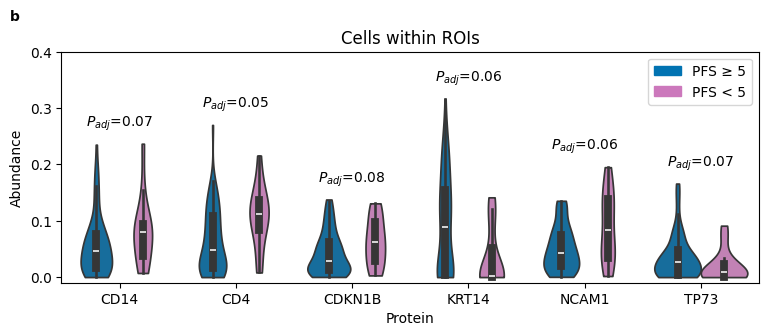

In [14]:
alpha = 0.1
melted = distri_df.melt(id_vars=['In ROI', 'Sample', 'PFS < 5'], var_name="Gene", value_name="Expression")
f, ax = plt.subplots(1, figsize=(9, 3), sharey=True)

subset = melted[melted["Gene"].isin(markers)] # 
palette = {0: blue, 1: pink}

sns.violinplot(data=subset[subset["In ROI"] == 1], x="Gene", y="Expression", ax=ax, hue="PFS < 5", palette=palette, order=markers, hue_order=[0, 1], cut=0) #legend=False, 

palette = {"PFS ≥ 5": blue, "PFS < 5": pink}
legend_handles = [Patch(color=color, label=key) for key, color in palette.items()]
ax.legend(handles=legend_handles, frameon=True)
ax.set_title("Cells within ROIs")
ax.set_ylabel("Abundance")
ax.set_xlabel("Protein")

for i, m in enumerate(markers):
    if pvals_roi[i] < alpha:
        y = np.max(distri_df[distri_df["In ROI"] == True][m])
        ax.text(i, y+0.02, f"$P_{{adj}}$={pvals_roi[i] :.2f}", ha='center', va='bottom')
ax.set_ylim([-0.01, 0.4])

ax.text(-0.9, 0.45, "b", ha='center', va='bottom', weight="bold")
plt.savefig("../result_plots/within_versus_rest.pdf", bbox_inches="tight")